In [41]:
import os
import sys
from google.colab import drive

if 'google.colab' in sys.modules:
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
if 'google.colab' in sys.modules:
  %pip install numpy matplotlib scikit-learn seaborn tensorflow
else:
  !pip install numpy matplotlib scikit-learn seaborn tensorflow

In [43]:
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Data Preparation

In [44]:
def count_images_in_directory(directory):
  """
  Utility function to count images in a given directory
  :param directory: The directory to count images in
  :return: None
  """
  total_count = 0
  for root, dirs, files in os.walk(directory):
    file_count = len(files)
    print(f"{root}: {file_count} images")
    total_count += file_count

In [45]:
BASE_PATH = os.getcwd() + '/Corrosion-dataset'

def data_preparation():
  """
  Prepare the data for training and testing
  :return: train_dir, test_dir
  """
  # Get the corrosion dataset and define two main classses, which are rust and no rust
  data_path = os.path.join(BASE_PATH, 'Corrosion')
  target_classes = ['rust', 'no rust']

  # Make train and test directory
  train_dir = os.path.join(data_path, 'train')
  test_dir = os.path.join(data_path, 'test')

  if not os.path.exists(train_dir):
    os.makedirs(train_dir)
  if not os.path.exists(test_dir):
    os.makedirs(test_dir)

  # Walk through the rust and no rust directory
  for c in target_classes:
    # Make rust and no rust folder if not exsits
    if not os.path.exists(os.path.join(train_dir, c)):
      os.makedirs(os.path.join(train_dir, c))
    if not os.path.exists(os.path.join(test_dir, c)):
      os.makedirs(os.path.join(test_dir, c))
    labeled_dir = os.path.join(data_path, c)
    # Append images into an array for spliting
    images = []
    for file in os.listdir(labeled_dir):
      if os.path.isfile(os.path.join(labeled_dir, file)):
        images.append(os.path.join(labeled_dir, file))

    # Using train_test_split to split 10 images for both rust and no rust
    train_images, test_images = train_test_split(images, test_size=10, random_state=1)

    # Put imags to the rust and no rust folder
    for image in train_images:
      shutil.copy(image, os.path.join(train_dir, c))
    for image in test_images:
      shutil.copy(image, os.path.join(test_dir, c))

  print(len(images))

  return train_dir, test_dir

In [46]:
print("Starting data preparation process...")
train_dir, test_dir = data_preparation()
count_images_in_directory(train_dir)
count_images_in_directory(test_dir)
print("Data preparation completed.")

Starting data preparation process...
15
/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/Corrosion/train: 0 images
/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/Corrosion/train/rust: 4 images
/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/Corrosion/train/no rust: 5 images
/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/Corrosion/test: 0 images
/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/Corrosion/test/rust: 10 images
/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/Corrosion/test/no rust: 10 images
Data preparation completed.


## 1. Basic CNN Model

In [47]:
def plot_accuracy(history, model_name):
  """
  Function to plot the accuracy of the model
  :param history: The history of the model
  :param model_name: The name of the model
  :return: None
  """
  plt.title(f"{model_name} accuracy")
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [48]:
def show_true_and_predicted_classes(model, test_generator):
  """
  Shows the true and predicted classes for the given model and test generator.
  :param model: The trained Keras model.
  :param test_generator: The test data generator.
  :return: None
  """

  # Get the true labels and predicted labels
  y_true = test_generator.classes
  y_pred = model.predict(test_generator).argmax(axis=1)
  filenames = test_generator.filenames

  # Print the true and predicted labels for each sample
  print("True and Predicted Classes:")
  for i in range(len(y_true)):
    print(f"Image {filenames[i]}: True = {y_true[i]}, Predicted = {y_pred[i]}")

  # Create a confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix using seaborn
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=test_generator.class_indices,
              yticklabels=test_generator.class_indices)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

In [49]:
from tensorflow.keras.utils import save_img

def save_predicted_images(model, test_generator, dir_to_save):
  """
  Function to save the predicted images
  :param model: The model to use
  :param test_generator: The test generator
  :param dir_to_save: The directory to save the images
  :return: None
  """
  if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)
  classes = list(test_generator.class_indices.keys())
  for batches_idx, (imgs, labels) in enumerate(test_generator):
    preds = model.predict(imgs)
    filenames = test_generator.filenames[batches_idx * test_generator.batch_size : (batches_idx + 1) * test_generator.batch_size]
    pred_class_indices = np.argmax(preds, axis=1)
    for i in range(imgs.shape[0]):
      img = imgs[i]
      pred_class_label = classes[pred_class_indices[i]]
      orig_filename = os.path.basename(filenames[i])
      path_to_save = os.path.join(dir_to_save, f"{os.path.splitext(orig_filename)[0]}_{pred_class_label}.png")
      save_img(path_to_save, img)
    if batches_idx == len(test_generator) -1:
      break

In [50]:
def with_basic_cnn(train_dir, test_dir):
  """
  Function to build, train and test the basic CNN model
  :param train_dir: The directory of the training data
  :param test_dir: The directory of the testing data
  :return: model_builder
  """
  # Define target image's width and height
  image_width, image_height = 32, 32
  # Create a sequential builder to build the model
  model_builder = Sequential([
    Input(shape=(image_width, image_height, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
  ])
  model_builder.summary()
  # Compile with adam and categorical crossentropy
  model_builder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # Convert train and test dataset using ImageDataGenerator
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
  test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
  # Fith with 20 epochs (100 steps per epoch)
  history = model_builder.fit(train_generator, epochs=20, steps_per_epoch=100, validation_data=test_generator, validation_steps=50)
  # Plot the accuracy
  plot_accuracy(history, "Basic CNN")
  show_true_and_predicted_classes(model_builder, test_generator)
  # Eval and save predicted images to the folder
  print(f"Test accuracy of Basic CNN: {model_builder.evaluate(test_generator)[1] * 100:.2f}%")
  print(f"Saving Predicted CNN to {BASE_PATH}/cnn_test")
  save_predicted_images(model_builder, test_generator, BASE_PATH + "/cnn_test")
  return model_builder

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,170 (621.76 KB)

 Trainable params: 159,170 (621.76 KB)

 Non-trainable params: 0 (0.00 B)

Found 9 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/100 ━━━━━━━━━━━━━━━━━━━━ 8:53 5s/step - accuracy: 0.4444 - loss: 0.7023

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4444 - loss: 0.7023 - val_accuracy: 0.5000 - val_loss: 0.6827
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5556 - loss: 0.6769 - val_accuracy: 0.5000 - val_loss: 0.6839
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5556 - loss: 0.6691 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5556 - loss: 0.6644 - val_accuracy: 0.5000 - val_loss: 0.6871
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 0.6549 - val_accuracy: 0.5000 - val_loss: 0.6763
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 0.6452 - val_accuracy: 0.5000 - val_loss: 0.6688
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5556 - loss: 0.6357 - val_accuracy: 0.5000 - val_loss: 0.6650
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5556 - loss: 0.6213 - val_accuracy: 0.5000 - val

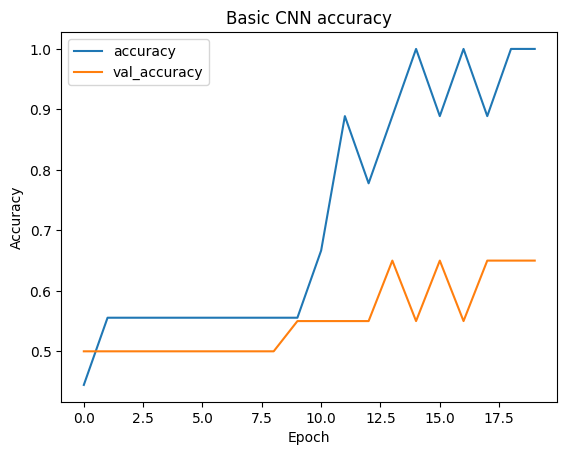

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
True and Predicted Classes:
Image no rust/001_0fwtaowy.t1o.jpg: True = 0, Predicted = 0
Image no rust/002_2bvturws.zss.jpg: True = 0, Predicted = 0
Image no rust/002_dr3selb3.a1h.jpg: True = 0, Predicted = 0
Image no rust/002_mjcgc4b1.ru0.jpg: True = 0, Predicted = 0
Image no rust/002_yoamnba2.wdq.jpg: True = 0, Predicted = 1
Image no rust/003_zomak3wq.43c.jpg: True = 0, Predicted = 0
Image no rust/006_2vq3zs35.40h.jpg: True = 0, Predicted = 0
Image no rust/006_esktmdp0.le4.jpg: True = 0, Predicted = 1
Image no rust/006_ri0wotdb.hsh.jpg: True = 0, Predicted = 0
Image no rust/007_drdnswnb.xeb.jpg: True = 0, Predicted = 0
Image rust/002_cql5orz2.p0y.jpg: True = 1, Predicted = 1
Image rust/002_q40jac40.sd4.jpg: True = 1, Predicted = 0
Image rust/003_glbjresp.01k.jpg: True = 1, Predicted = 0
Image rust/004_i1dmciub.oop.jpg: True = 1, Predicted = 0
Image rust/004_liem2hdg.3w2.jpg: True = 1, Predicted = 0
Image rust/004_uouhxp2m.0ax.jpg: True = 1, Predi

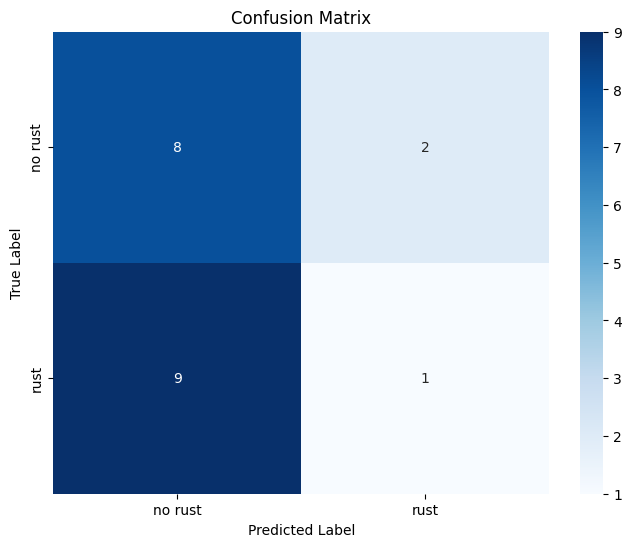

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6500 - loss: 0.6024
Test accuracy of Basic CNN: 65.00%
Saving Predicted CNN to /content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/cnn_test
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


In [51]:
cnn_model = with_basic_cnn(train_dir, test_dir)
cnn_model.save(BASE_PATH + "/models/simple_cnn.keras")

## 2. ResNet 50

In [52]:
def with_resnet50(train_dir, test_dir):
  """
  Function to build, train and test the ResNet50 model
  :param train_dir: The directory of the training data
  :param test_dir: The directory of the testing data
  :return: model_builder
  """
  # Define target image's width and height
  image_width, image_height = 224, 224
  # Get the initial ResNet50 and freeze it
  initial_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
  initial_resnet50.trainable = False
  # Create a sequential builder for initial ResNet50 and add some more layers
  model_builder = Sequential([
      initial_resnet50,
      GlobalAveragePooling2D(),
      Dense(128, activation='relu'),
      Dense(2, activation='softmax')
  ])
  model_builder.summary()
  # Compile with adam and categorical crossentropy
  model_builder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # Convert train and test dataset using ImageDataGenerator
  train_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
  test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_width, image_height), batch_size=32, class_mode='categorical')
  print("Test generator: ", test_generator)
  # Fith with 20 epochs (100 steps per epoch)
  history = model_builder.fit(train_generator, epochs=20, steps_per_epoch=100, validation_data=test_generator, validation_steps=50)
  # Plot the accuracy
  plot_accuracy(history, "ResNet50")
  show_true_and_predicted_classes(model_builder, test_generator)
  # Eval and save predicted images to the folder
  print(f"Test accuracy of ResNet50: {model_builder.evaluate(test_generator)[1] * 100:.2f}%")
  print(f"Saving Predicted CNN to {BASE_PATH}/resnet50_test")
  save_predicted_images(model_builder, test_generator, BASE_PATH + "/resnet50_test")
  return model_builder

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 9 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Test generator:  <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7eab4cb97810>
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/100 ━━━━━━━━━━━━━━━━━━━━ 31:13 19s/step - accuracy: 0.4444 - loss: 0.8576

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.4444 - loss: 0.8576 - val_accuracy: 0.5000 - val_loss: 0.7756
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 0.7260 - val_accuracy: 0.5000 - val_loss: 0.8554
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 0.7874 - val_accuracy: 0.5000 - val_loss: 0.7679
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5556 - loss: 0.7202 - val_accuracy: 0.5000 - val_loss: 0.6987
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 0.6840 - val_accuracy: 0.5000 - val_loss: 0.7125
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4444 - loss: 0.7225 - val_accuracy: 0.5000 - val_loss: 0.7204
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4444 - loss: 0.7341 - val_accuracy: 0.5000 - val_loss: 0.7010
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4444 - loss: 0.7013 - val_accuracy: 0.5000 - va

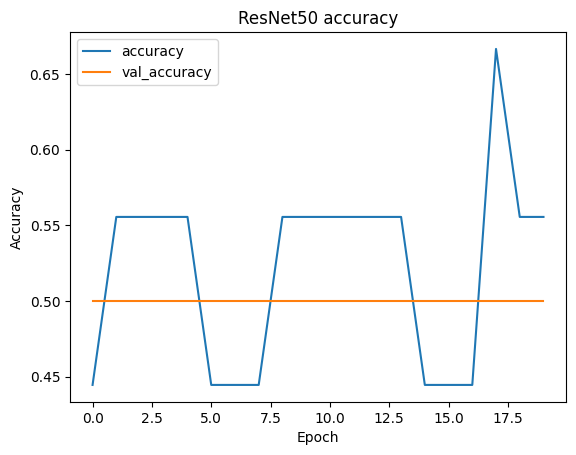

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
True and Predicted Classes:
Image no rust/001_0fwtaowy.t1o.jpg: True = 0, Predicted = 0
Image no rust/002_2bvturws.zss.jpg: True = 0, Predicted = 0
Image no rust/002_dr3selb3.a1h.jpg: True = 0, Predicted = 0
Image no rust/002_mjcgc4b1.ru0.jpg: True = 0, Predicted = 0
Image no rust/002_yoamnba2.wdq.jpg: True = 0, Predicted = 0
Image no rust/003_zomak3wq.43c.jpg: True = 0, Predicted = 0
Image no rust/006_2vq3zs35.40h.jpg: True = 0, Predicted = 0
Image no rust/006_esktmdp0.le4.jpg: True = 0, Predicted = 0
Image no rust/006_ri0wotdb.hsh.jpg: True = 0, Predicted = 0
Image no rust/007_drdnswnb.xeb.jpg: True = 0, Predicted = 0
Image rust/002_cql5orz2.p0y.jpg: True = 1, Predicted = 0
Image rust/002_q40jac40.sd4.jpg: True = 1, Predicted = 0
Image rust/003_glbjresp.01k.jpg: True = 1, Predicted = 0
Image rust/004_i1dmciub.oop.jpg: True = 1, Predicted = 0
Image rust/004_liem2hdg.3w2.jpg: True = 1, Predicted = 0
Image rust/004_uouhxp2m.0ax.jpg: True = 1, Predicte

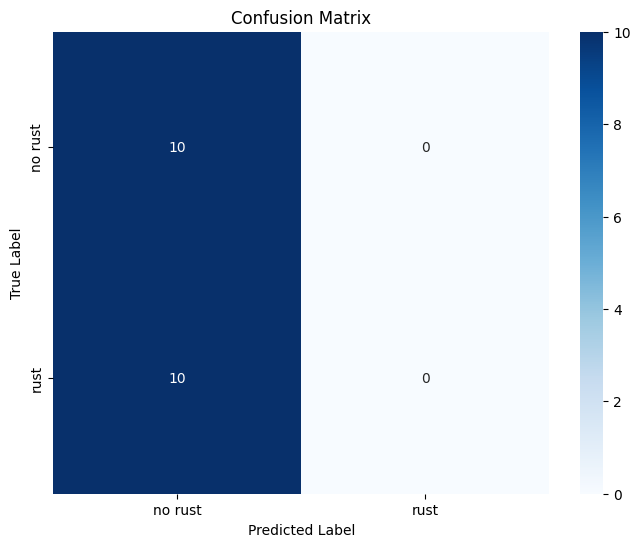

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5000 - loss: 0.7284
Test accuracy of ResNet50: 50.00%
Saving Predicted CNN to /content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 4/Corrosion-dataset/resnet50_test
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [53]:
resnet_model = with_resnet50(train_dir, test_dir)
resnet_model.save(BASE_PATH + "/models/resnet50.keras")